# Time Series Project

##Preperations and Cleaning

###Call Required Packages

In [251]:
import datetime
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn import metrics

from time import sleep
import csv
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LassoLarsCV

In [252]:
##!pip install --upgrade statsmodels

###Read in the Data

In [253]:
googletrends = pd.read_csv('/content/drive/MyDrive/APRD6343 Time Series/Data/hulu.csv', skiprows = [0,1], parse_dates = ['Week'])
newtrends = pd.read_csv('/content/drive/MyDrive/APRD6343 Time Series/Data/hulunew.csv', skiprows = [0,1], parse_dates = ['Week'])
newtrends.drop(newtrends.tail(1).index,inplace=True)
adspend = pd.read_csv('/content/drive/MyDrive/APRD6343 Time Series/Data/hulu.adspend.csv')

In [254]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [255]:
googletrends

,Week,Hulu: (United States)
0,2013-10-06,91
1,2013-10-13,90
2,2013-10-20,84
3,2013-10-27,85
4,2013-11-03,86
...,...,...
258,2018-09-16,75
259,2018-09-23,100
260,2018-09-30,84
261,2018-10-07,77


##Prophet Forecast

In [256]:
prophetdata = pd.DataFrame()
prophetdata['y'] = googletrends['Hulu: (United States)']
prophetdata['ds'] = googletrends['Week']

In [257]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(prophetdata)
future = m.make_future_dataframe(periods=52, freq='W')
future.tail()

,ds
310,2019-09-15
311,2019-09-22
312,2019-09-29
313,2019-10-06
314,2019-10-13


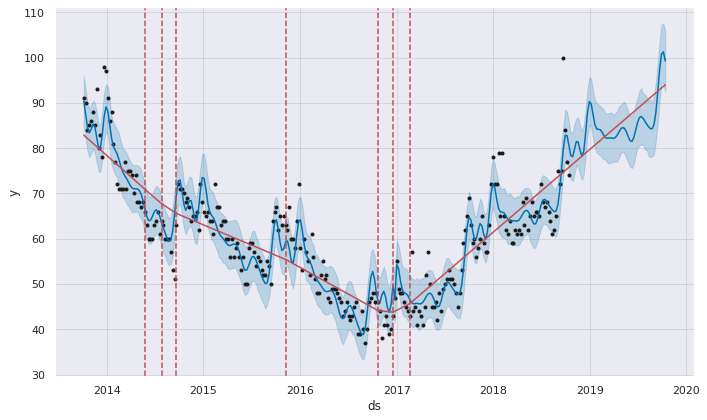

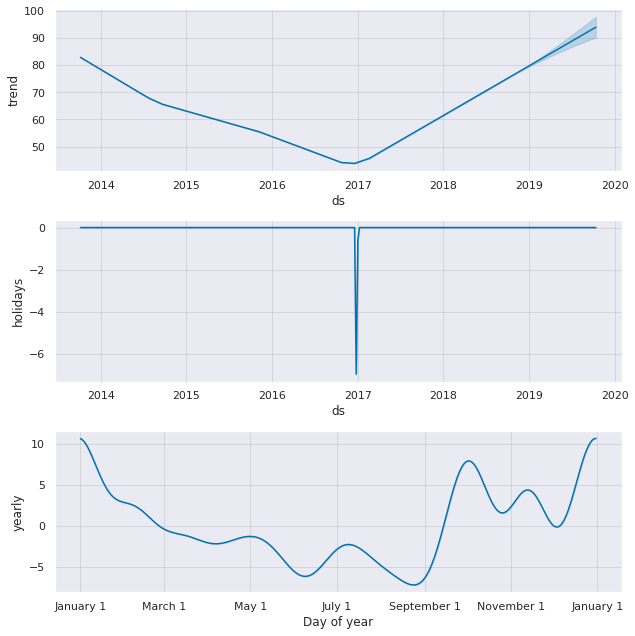

In [258]:
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

###Holidays and Changepoints in Prophet

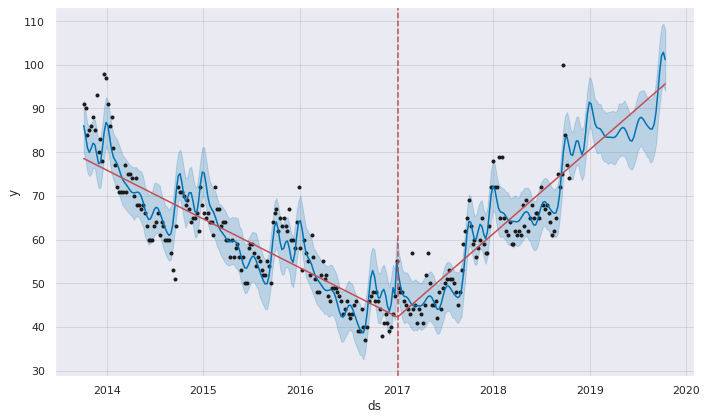

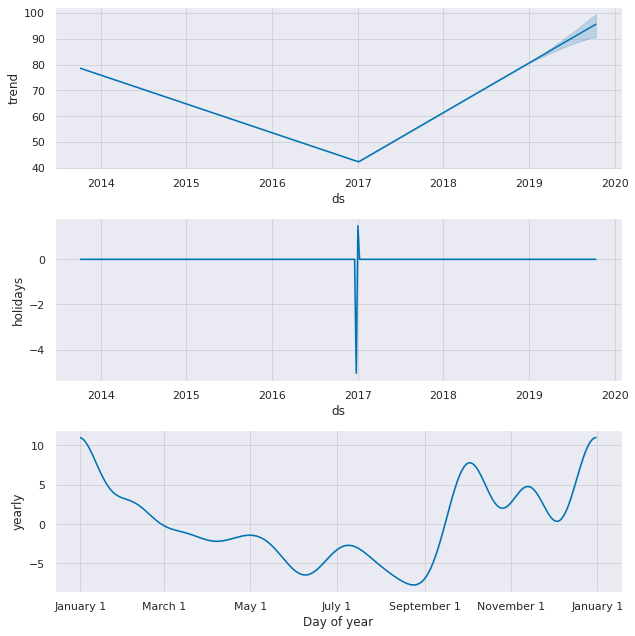

In [259]:
changepoints = ['2015-07-12','2015-09-02','2016-06-16','2017-01-04','2017-05-03','2018-04-11']
m = Prophet(changepoints=changepoints)
m.add_country_holidays(country_name='US')
m.fit(prophetdata)
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

##Stationary, PACF ACF, ARIMA

In [260]:
def adf_test(timeseries):
  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries,autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [261]:
googletrends.index = googletrends['Week']
del googletrends['Week']
newtrends.index = newtrends['Week']
del newtrends['Week']
newtrends.tail()

,Hulu: (United States)
Week,
2019-09-08,75
2019-09-15,66
2019-09-22,71
2019-09-29,77
2019-10-06,72


In [262]:
print(googletrends['Hulu: (United States)'].describe())

count    263.000000
mean      60.121673
std       12.492762
min       37.000000
25%       50.000000
50%       60.000000
75%       67.000000
max      100.000000
Name: Hulu: (United States), dtype: float64


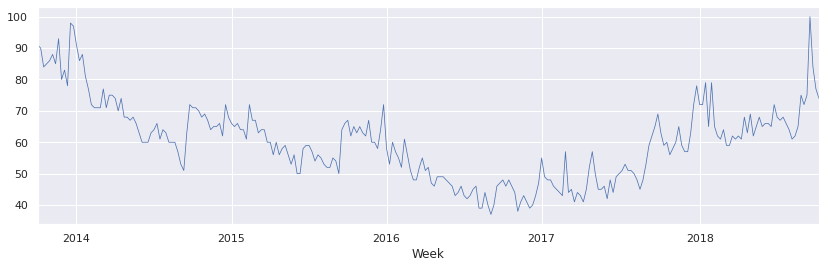

In [263]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
googletrends['Hulu: (United States)'].plot(linewidth=0.75)

###ADF/ACF/PACF

Now that we have the data parsed, we're going to work towards modeling this data using a common method in statistics: ARIMA. But to do that, we need to learn about the data a little bit first.

First, we need to learn if the data is stationary. If it's not, we need to incorporate some type of integration component in our model. Put another way, if the data has a mean that changes across time, we're going to need to do something about that later in our ARIMA.

In [264]:
adf_test(googletrends['Hulu: (United States)'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.346595
p-value                          0.157380
#Lags Used                       7.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


The p here is > .05. The null hypothesis for both tests is that the data are non-stationary. We want to REJECT the null hypothesis for this test, so we want a p-value of less that 0.05 (or smaller). Our p > .05, so the mean appears to change across time. We're going to want to build a model that removes this stationarity from our data before we model seasonality and autoregression.

Another way to remove stationarity from a time series is to difference it. Let's take a look at what differencing is.

In [265]:
googletrends['trends_diff_1'] = googletrends['Hulu: (United States)'].diff(1)
newtrends['trends_diff_1'] = newtrends['Hulu: (United States)'].diff(1)

In [266]:
googletrends

,Hulu: (United States),trends_diff_1
Week,,
2013-10-06,91,NaN
2013-10-13,90,-1.0
2013-10-20,84,-6.0
2013-10-27,85,1.0
2013-11-03,86,1.0
...,...,...
2018-09-16,75,3.0
2018-09-23,100,25.0
2018-09-30,84,-16.0


A difference is just the change from one time measurement to another. The change from 88 to 86 == -2. The change from 86 to 86 == 0, and so on. First order differencing is just taking the last measurement, but you can difference multiple time periods at once. Typically, 2nd, 3rd and 4th order differencing are only done if first order differencing doesn't make the data stationary.

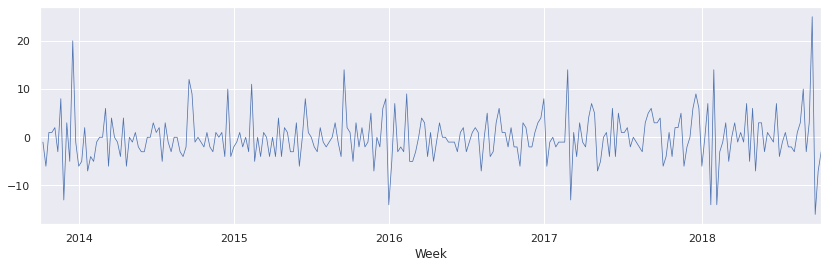

In [267]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
googletrends['trends_diff_1'].plot(linewidth=0.75)

In [268]:
adf_test(googletrends['trends_diff_1'][1:])

Results of Dickey-Fuller Test:
Test Statistic                -8.859033e+00
p-value                        1.500313e-14
#Lags Used                     6.000000e+00
Number of Observations Used    2.550000e+02
Critical Value (1%)           -3.456257e+00
Critical Value (5%)           -2.872942e+00
Critical Value (10%)          -2.572846e+00
dtype: float64


If we're going to build an ARIMA model, we need to know a bit about how the data tends to fluctuate consistently across time. We're going to manually model these behaviors using time series components. These are called the lag values for the Autoregression (AR) and Moving Average (MA) parameters, or p and q parameters for an ARIMA model, respectively.

The autocorrelation plot checks the degree to which past datapoints inform future ones. A lag of 1 days says that the value from yesterday informs the value of this week.

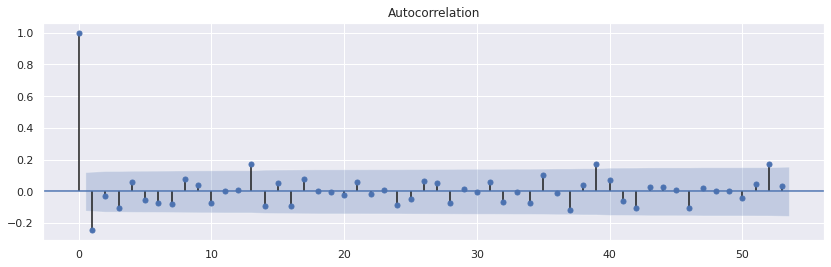

In [269]:
plot_acf(googletrends['trends_diff_1'][1:], lags=53);

If the lag effect goes beyond the blue shaded region, it's worth considering for a model. For this data, I'm seeing AR(1), AR(13), AR(39), and AR(52).

Now, let's think about partial autocorrelation.

The moving average process is an autoregression model of the time series of residual errors from what we've already modeled with AR.

Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

More recent trends that are not subject to the same types of calendar effects (e.g., day of week, month, so on).

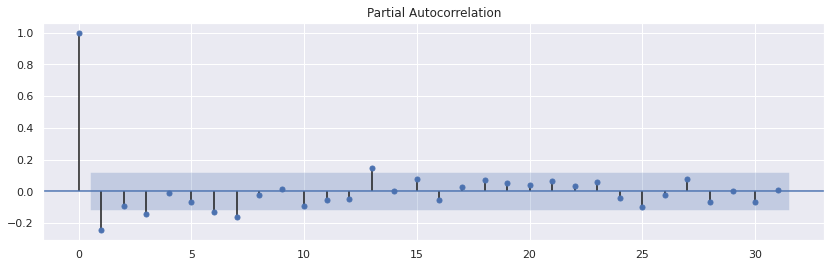

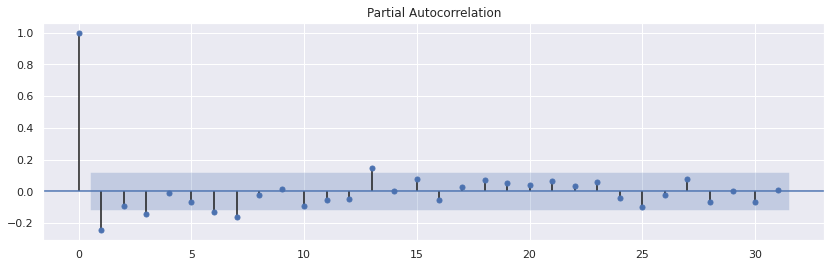

In [270]:
plot_pacf(googletrends['trends_diff_1'][1:], lags=31)

Possibly MA(1). That is, the residual error could be correlated up to 1 day.

###ARIMA Modeling

In [271]:
model = ARIMA(googletrends['Hulu: (United States)'], order=(1,1,1))
model_fit = model.fit()
summary = model_fit.summary().as_text()
for aline in summary.split(','):
  print(aline)

                                ARIMA Model Results                                
Dep. Variable:     D.Hulu: (United States)   No. Observations:                  262
Model:                      ARIMA(1
 1
 1)   Log Likelihood                -776.687
Method:                            css-mle   S.D. of innovations              4.688
Date:                     Fri
 30 Apr 2021   AIC                           1561.374
Time:                             21:21:59   BIC                           1575.647
Sample:                         10-13-2013   HQIC                          1567.111
                              - 10-14-2018                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0480      0.124     -0.388      0.699      -0.291       0.195
ar.L1.D.Hulu: (United States)     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [272]:
#model = ARIMA(googletrends['Hulu: (United States)'], order=(2,1,1))
#model_fit = model.fit()
#summary = model_fit.summary().as_text()
#for aline in summary.split(','):
#  print(aline)

In [273]:
#model = ARIMA(googletrends['Hulu: (United States)'], order=(2,1,2))
#model_fit = model.fit()
#summary = model_fit.summary().as_text()
#for aline in summary.split(','):
#  print(aline)

In [274]:
#model = ARIMA(googletrends['Hulu: (United States)'], order=(1,0,1))
#model_fit = model.fit()
#summary = model_fit.summary().as_text()
#for aline in summary.split(','):
#  print(aline)

####Durbin Watson

A Durbin Watson ranges 0-4. We're looking for a value close to 2. This suggests no autocorrelations amongst residuals, e.g., that we've modeled just about all we can out of the data with lags. That's the case here!

In [275]:
model_fit.resid.head()

Week
2013-10-13   -0.951994
2013-10-20   -6.155421
2013-10-27   -0.574617
2013-11-03    0.098727
2013-11-10    1.609512
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



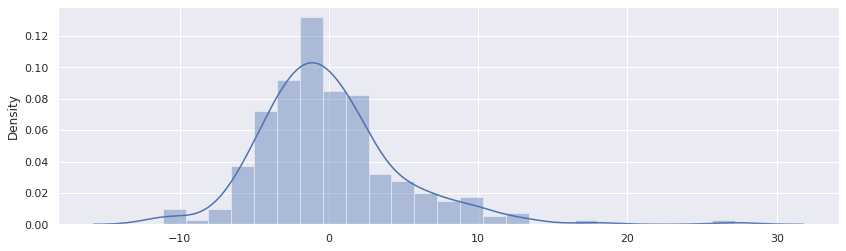

In [276]:
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist=True, kde=True)

In [277]:
print(durbin_watson(residuals))

[2.0454871]


In [278]:
absresiduals = abs(residuals)
print(np.mean(abs(residuals)))

0    3.395033
dtype: float64


In [279]:
print(googletrends['Hulu: (United States)'].describe())

count    263.000000
mean      60.121673
std       12.492762
min       37.000000
25%       50.000000
50%       60.000000
75%       67.000000
max      100.000000
Name: Hulu: (United States), dtype: float64


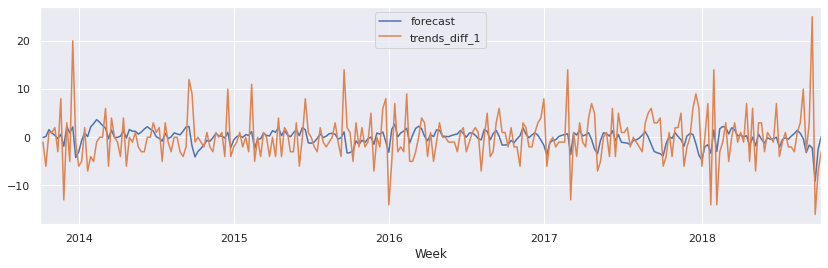

In [280]:
pd.plotting.register_matplotlib_converters()    
ax = model_fit.predict().plot(label="forecast")
googletrends['trends_diff_1'].plot(ax=ax)
ax.legend()

In [281]:
model_fit.aic

1561.3738340636637

##SARIMA Modeling

In [282]:
model = sm.tsa.statespace.SARIMAX(googletrends['Hulu: (United States)'], trend='t', order=(1,1,1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



                             Statespace Model Results                            
Dep. Variable:     Hulu: (United States)   No. Observations:                  263
Model:                  SARIMAX(1, 1, 1)   Log Likelihood                -776.368
Date:                   Fri, 30 Apr 2021   AIC                           1560.737
Time:                           21:22:01   BIC                           1575.010
Sample:                       10-06-2013   HQIC                          1566.474
                            - 10-14-2018                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0004      0.000      0.749      0.454      -0.001       0.001
ar.L1          0.4908      0.105      4.652      0.000       0.284       0.698
ma.L1         -0.7884      0

This is a pretty good model! Is it better than your ARIMA model? No, it is not.

Let's add a seasonal component now. There's very little documentation on how seasonality works in an SARIMA model (via the seasonal_order), but know that in general, the last parameter corresponds to the type of seasonality we'd expect. We saw some longer autoregressive significance at lag 14, so lets try that. The first three parameters refer to AR I and MA components again. Think of the AR and MA components as the number of past seasonality points that you would expect to see a seasonal effect. 

So let's start here with the idea of a 7 day (weekly) seasonality. We'll feed the model (2,0,2) because we expect to see this effect up to four weeks out.

In [283]:
#model = sm.tsa.statespace.SARIMAX(googletrends['Hulu: (United States)'], trend='t', order=(1,1,1), seasonal_order=(2,0,2,7))
#model_fit = model.fit(disp=False)
#print(model_fit.summary())

In [284]:
#model = sm.tsa.statespace.SARIMAX(googletrends['Hulu: (United States)'], trend='t', order=(1,1,1), seasonal_order=(1,0,1,7))
#model_fit = model.fit(disp=False)
#print(model_fit.summary())

In [285]:
#model = sm.tsa.statespace.SARIMAX(googletrends['Hulu: (United States)'], trend='t', order=(1,1,1), seasonal_order=(1,0,1,2))
#model_fit = model.fit(disp=False)
#print(model_fit.summary())

In [286]:
model = sm.tsa.statespace.SARIMAX(googletrends['Hulu: (United States)'], trend='t', order=(1,1,1), seasonal_order=(1,0,0,7))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



                                 Statespace Model Results                                
Dep. Variable:             Hulu: (United States)   No. Observations:                  263
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 7)   Log Likelihood                -775.357
Date:                           Fri, 30 Apr 2021   AIC                           1560.715
Time:                                   21:22:03   BIC                           1578.556
Sample:                               10-06-2013   HQIC                          1567.886
                                    - 10-14-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0004      0.001      0.722      0.471      -0.001       0.002
ar.L1          0.4465      0.119      3.742

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



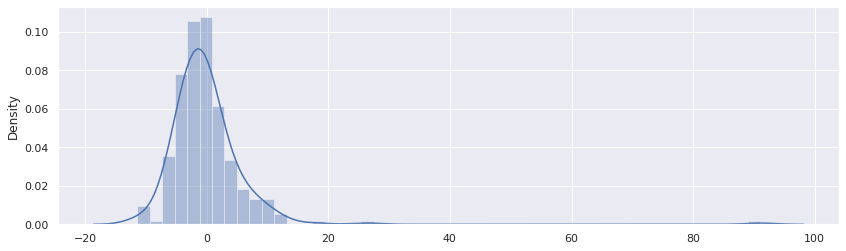

In [287]:
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist=True, kde=True)

In [288]:
print(googletrends['Hulu: (United States)'].describe())

count    263.000000
mean      60.121673
std       12.492762
min       37.000000
25%       50.000000
50%       60.000000
75%       67.000000
max      100.000000
Name: Hulu: (United States), dtype: float64


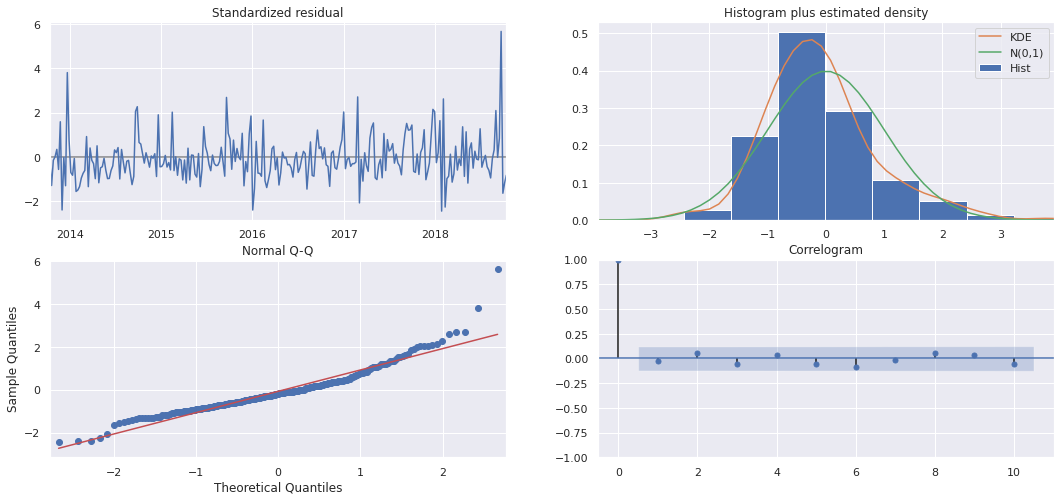

In [289]:
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

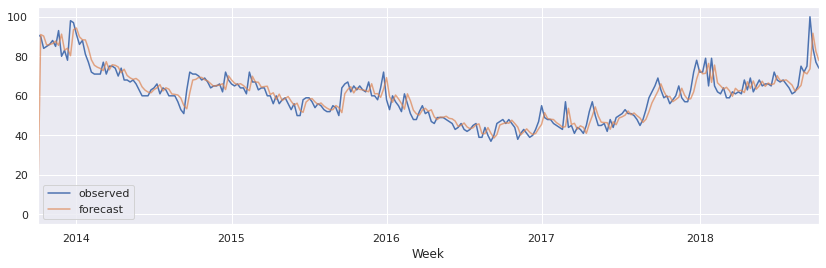

In [290]:
pred = model_fit.get_prediction()
pred_ci = model_fit.conf_int()
ax = googletrends['Hulu: (United States)'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))
plt.legend()
plt.show()

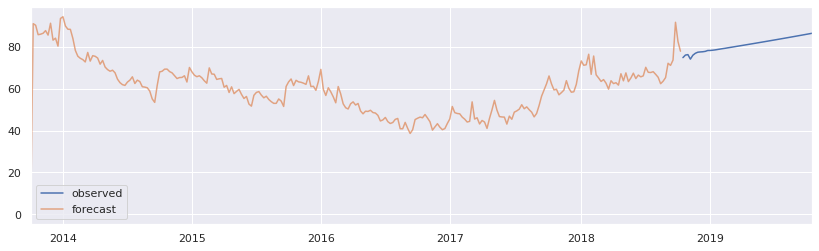

In [291]:
fcast = model_fit.predict(len(googletrends['Hulu: (United States)']),len(googletrends['Hulu: (United States)'])+52)
ax = fcast.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))
plt.legend()
plt.show()

In [292]:
future

,ds
0,2013-10-06
1,2013-10-13
2,2013-10-20
3,2013-10-27
4,2013-11-03
...,...
310,2019-09-15
311,2019-09-22
312,2019-09-29
313,2019-10-06


In [293]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

2013-10-06     0.000684
2013-10-13    91.000178
2013-10-20    90.227252
2013-10-27    85.736542
2013-11-03    85.974964
2013-11-10    86.409123
2013-11-17    87.671014
2013-11-24    85.544730
2013-12-01    91.197489
2013-12-08    83.130336
2013-12-15    84.073523
2013-12-22    80.275346
Freq: W-SUN, dtype: float64

##Sarimax Modeling

In [294]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),SUNDAY MAGS DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Hulu : Online,47.8,0.0,0.0,0.0,47.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Hulu Online & Hulu Plus Online : Combo,4.2,0.0,0.0,0.0,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"WEEK OF OCT 07, 2013 (B)",Hulu Plus : Online,763.2,0.0,363.8,379.9,19.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"WEEK OF OCT 14, 2013 (B)",Hulu : Online,40.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"WEEK OF OCT 14, 2013 (B)",Hulu Online & Hulu Plus Online : Combo,3.6,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [295]:
adspend.columns

Index(['TIME PERIOD', 'PRODUCT', 'TOTAL DOLS (000)', 'NETWORK TV DOLS (000)',
       'CABLE TV DOLS (000)', 'SYNDICATION DOLS (000)', 'SPOT TV DOLS (000)',
       'MAGAZINES DOLS (000)', 'SUNDAY MAGS DOLS (000)',
       'NATL NEWSP DOLS (000)', 'NEWSPAPER DOLS (000)',
       'NETWORK RADIO DOLS (000)', 'NAT SPOT RADIO DOLS (000)',
       'OUTDOOR DOLS (000)'],
      dtype='object')

In [296]:
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF ", "")
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("\(B\)", "") #\escape character
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "") #\escape character
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])
adspendnoproducts=adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)

In [297]:
adspendnoproducts.index

DatetimeIndex(['2013-10-07', '2013-10-14', '2013-10-21', '2013-10-28',
               '2013-11-04', '2013-11-11', '2013-11-18', '2013-11-25',
               '2013-12-02', '2013-12-09',
               ...
               '2018-07-30', '2018-08-06', '2018-08-13', '2018-08-20',
               '2018-08-27', '2018-09-03', '2018-09-10', '2018-09-17',
               '2018-09-24', '2018-10-01'],
              dtype='datetime64[ns]', name='FIXED TIME', length=261, freq=None)

In [298]:
adspendnoproducts

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,SYNDICATION,TOTAL
FIXED TIME,,,,,,,,,,,,
2013-10-07,363.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.5,0.0,379.9,815.2
2013-10-14,325.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.2,0.0,250.5,619.8
2013-10-21,369.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.5,0.0,253.9,668.3
2013-10-28,400.6,0.0,0.0,0.0,1.7,0.0,0.0,563.5,45.9,0.0,143.3,1155.0
2013-11-04,402.3,0.0,0.0,0.0,4.0,430.8,0.0,0.0,48.3,0.0,152.6,1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-03,15.8,0.0,46.5,0.0,0.0,584.0,0.0,0.0,42.9,0.0,0.0,689.3
2018-09-10,23.0,0.0,46.5,0.0,0.0,584.0,0.0,0.0,8.8,0.0,0.0,662.4
2018-09-17,642.4,0.0,46.5,0.0,0.0,4754.4,0.0,0.0,26.6,0.0,0.0,5470.0


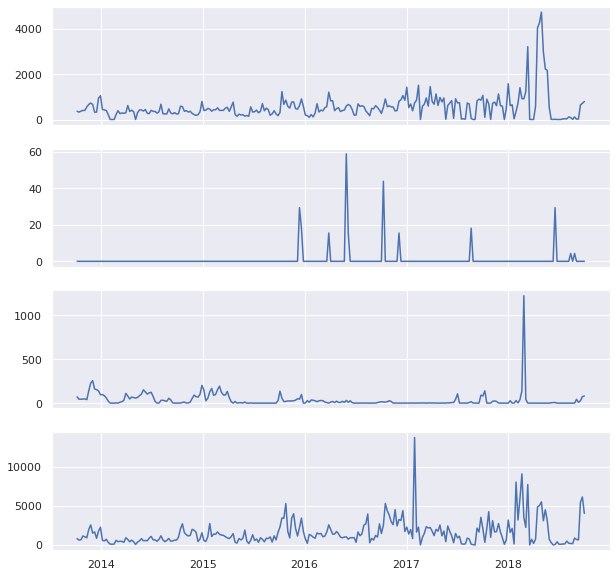

In [299]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=dimensions, sharex='all') # have the one x axis printed for all 4 graphs instead of for each graph

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV']) #Spot cable is one of two basic ways to buy advertising on cable television. It allows regional small-business owners to show their TV ads on national cable networks that air in their local markets without having to buy airtime from those networks.
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

In [300]:
testdate = pd.to_datetime("2013-10-07")
testdate.weekday() # this is monday

0

In [301]:
googletrends.head()

,Hulu: (United States),trends_diff_1
Week,,
2013-10-06,91,NaN
2013-10-13,90,-1.0
2013-10-20,84,-6.0
2013-10-27,85,1.0
2013-11-03,86,1.0


In [302]:
adspendnoproducts['FIXED DATE'] = adspendnoproducts.index - pd.DateOffset(1)
adspendnoproducts['FIXED DATE']

FIXED TIME
2013-10-07   2013-10-06
2013-10-14   2013-10-13
2013-10-21   2013-10-20
2013-10-28   2013-10-27
2013-11-04   2013-11-03
                ...    
2018-09-03   2018-09-02
2018-09-10   2018-09-09
2018-09-17   2018-09-16
2018-09-24   2018-09-23
2018-10-01   2018-09-30
Name: FIXED DATE, Length: 261, dtype: datetime64[ns]

In [303]:
adspendnoproducts.index = adspendnoproducts['FIXED DATE']
del adspendnoproducts['FIXED DATE']

In [304]:
adspendnoproducts

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,SYNDICATION,TOTAL
FIXED DATE,,,,,,,,,,,,
2013-10-06,363.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.5,0.0,379.9,815.2
2013-10-13,325.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.2,0.0,250.5,619.8
2013-10-20,369.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.5,0.0,253.9,668.3
2013-10-27,400.6,0.0,0.0,0.0,1.7,0.0,0.0,563.5,45.9,0.0,143.3,1155.0
2013-11-03,402.3,0.0,0.0,0.0,4.0,430.8,0.0,0.0,48.3,0.0,152.6,1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-02,15.8,0.0,46.5,0.0,0.0,584.0,0.0,0.0,42.9,0.0,0.0,689.3
2018-09-09,23.0,0.0,46.5,0.0,0.0,584.0,0.0,0.0,8.8,0.0,0.0,662.4
2018-09-16,642.4,0.0,46.5,0.0,0.0,4754.4,0.0,0.0,26.6,0.0,0.0,5470.0


In [305]:
googletrends['TOTAL ADSPEND'] = adspendnoproducts['TOTAL']

In [306]:
googletrends

,Hulu: (United States),trends_diff_1,TOTAL ADSPEND
Week,,,
2013-10-06,91,NaN,815.2
2013-10-13,90,-1.0,619.8
2013-10-20,84,-6.0,668.3
2013-10-27,85,1.0,1155.0
2013-11-03,86,1.0,1038.0
...,...,...,...
2018-09-16,75,3.0,5470.0
2018-09-23,100,25.0,6155.0
2018-09-30,84,-16.0,4040.1


In [307]:
googletrends_droplastrow = googletrends[:-2]

In [308]:
model = sm.tsa.statespace.SARIMAX(googletrends_droplastrow['Hulu: (United States)'], trend='t', order=(1,1,0), exog = googletrends_droplastrow['TOTAL ADSPEND'])
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



                             Statespace Model Results                            
Dep. Variable:     Hulu: (United States)   No. Observations:                  261
Model:                  SARIMAX(1, 1, 0)   Log Likelihood                -773.889
Date:                   Fri, 30 Apr 2021   AIC                           1555.779
Time:                           21:22:08   BIC                           1570.021
Sample:                       10-06-2013   HQIC                          1561.504
                            - 09-30-2018                                         
Covariance Type:                     opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
drift             0.0016      0.002      0.722      0.470      -0.003       0.006
TOTAL ADSPEND   9.01e-05      0.000      0.536      0.592      -0.000       0.000
ar.L1           

##Pyramid Auto_ARIMA

In [309]:
stepwise_fit = auto_arima(googletrends_droplastrow['Hulu: (United States)'], start_p=0, start_q=0,
                             max_p=30, max_q=6, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1299.385, Time=10.66 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1322.112, Time=0.99 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1263.224, Time=5.76 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1252.467, Time=10.80 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1278.338, Time=0.91 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1254.280, Time=16.49 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1252.891, Time=5.74 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1254.105, Time=17.01 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=1254.265, Time=15.31 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1260.721, Time=9.67 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=inf, Time=44.22 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1250.578, Time=13.71 sec
 ARIMA(0,1,1)(0,1,0)[52] inte

In [310]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -621.289
Date:                            Fri, 30 Apr 2021   AIC                           1250.578
Time:                                    21:26:59   BIC                           1263.928
Sample:                                         0   HQIC                          1255.976
                                            - 261                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1977      0.099      2.004      0.045       0.004       0.391
ma.L1         -0.5709      0.052    -11.005      0.000      -0.673      -0.469
ma.S.L52      -0.5002      0.083     -6.042      0.000      -0.662      -0.338
sigma2        21.3793      1.885     11.344      0.000      17.686      25.073
===================================================================================
Ljung-Box (Q):                       40.27   Jarque-Bera (JB):                52.49
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.75
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [311]:
model = sm.tsa.statespace.SARIMAX(googletrends['Hulu: (United States)'], trend='t', order=(0, 1, 1), seasonal_order=(0, 1, 1, 52))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



                                 Statespace Model Results                                 
Dep. Variable:              Hulu: (United States)   No. Observations:                  263
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -628.315
Date:                            Fri, 30 Apr 2021   AIC                           1264.629
Time:                                    21:27:56   BIC                           1278.018
Sample:                                10-06-2013   HQIC                          1270.042
                                     - 10-14-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0011      0.001      1.800      0.072   -9.44e-05       0.002
ma.L1         -0.5692      0.051   

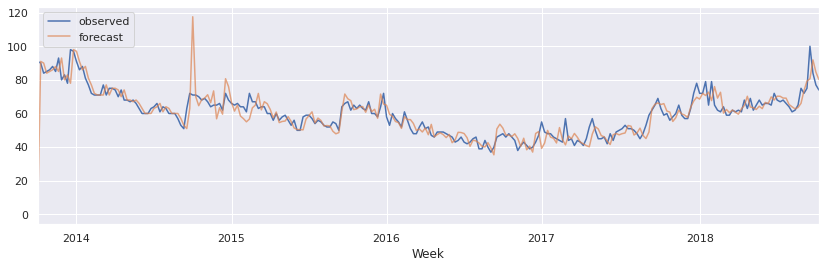

In [312]:
pred = model_fit.get_prediction()
pred_ci = model_fit.conf_int()
ax = googletrends['Hulu: (United States)'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))
plt.legend()
plt.show()

In [313]:
y_forecasted = pred.predicted_mean
y_truth = googletrends['Hulu: (United States)']
mae = metrics.mean_absolute_error(y_truth, y_forecasted)
mse = metrics.mean_squared_error(y_truth, y_forecasted)
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Absolute Error of our forecasts is 4.05
The Mean Squared Error of our forecasts is 63.28
The Root Mean Squared Error of our forecasts is 7.95


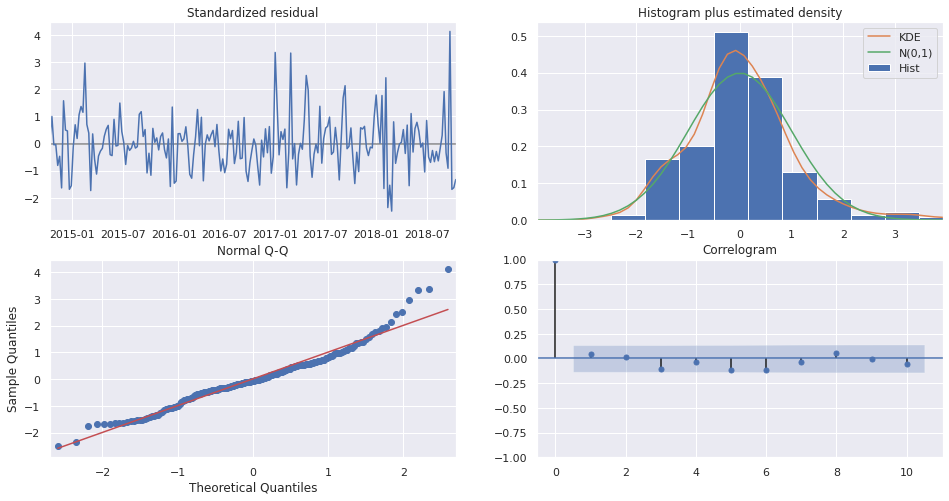

In [314]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

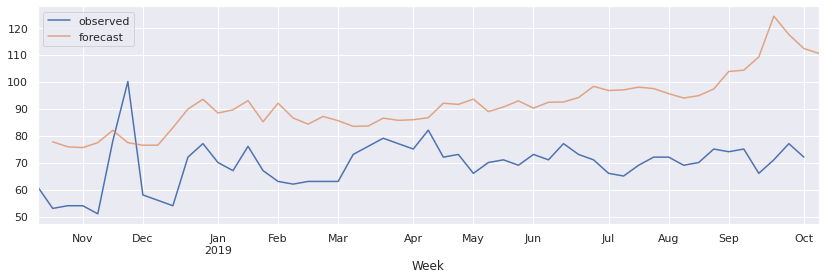

In [315]:
fcast = model_fit.get_forecast(steps=52)
fcast_ci = fcast.conf_int()
ax = newtrends['Hulu: (United States)'].plot(label='observed')
fcast.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))
plt.legend()
plt.show()

In [316]:
#newtrends.drop(newtrends.tail(1).index,inplace=True)

In [317]:
forecasted = fcast.predicted_mean
truth = newtrends['Hulu: (United States)']
mse = metrics.mean_squared_error(truth, forecasted)
mae = metrics.mean_absolute_error(truth, forecasted)
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Absolute Error of our forecasts is 23.1
The Mean Squared Error of our forecasts is 628.62
The Root Mean Squared Error of our forecasts is 25.07


In [ ]:
# stepwise_fit = auto_arima(googletrends_droplastrow['Hulu: (United States)'], start_p=0, start_q=0,
#                              max_p=30, max_q=30,
#                              seasonal=False,
#                              d=1, trace=True,
#                              error_action='ignore',
#                              suppress_warnings=True,
#                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1573.046, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1554.662, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1551.545, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1571.054, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1550.007, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1550.364, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1550.694, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1552.589, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1555.141, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1551.256, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1548.066, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1549.550, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1552.665, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1548.428, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [ ]:
# stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -771.033
Date:                Fri, 30 Apr 2021   AIC                           1548.066
Time:                        02:25:18   BIC                           1558.748
Sample:                             0   HQIC                          1552.360
                                - 261                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4566      0.121      3.776      0.000       0.220       0.694
ma.L1         -0.7523      0.097     -7.717      0.000      -0.943      -0.561
sigma2        22.0271      1.087     20.266      0.000      19.897      24.157
===================================================================================
Ljung-Box (Q):                       56.29   Jarque-Bera (JB):               294.45
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             1.26
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# stepwise_fit = auto_arima(googletrends_droplastrow['Hulu: (United States)'], start_p=0, start_q=0,
#                              max_p=30, max_q=6, m=52,
#                              start_P=0, seasonal=True,
#                              d=1, D=1, trace=True,
#                              error_action='ignore',
#                              suppress_warnings=True,
#                              stepwise=True,
#                              exogenous= googletrends_droplastrow['TOTAL ADSPEND'].values.reshape(-1, 1))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1301.345, Time=24.93 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1323.210, Time=3.07 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1268.485, Time=10.66 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1254.248, Time=41.74 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1279.797, Time=3.85 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1256.308, Time=57.72 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1255.588, Time=26.23 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1256.024, Time=45.27 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=1256.109, Time=48.46 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1262.254, Time=31.33 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=1258.270, Time=48.93 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1252.554, Time=43.61 sec
 ARIMA(0,1,1)(0,1,0)[

In [123]:
# adspend_trend = googletrends_droplastrow['TOTAL ADSPEND'].rolling(window=4).mean().fillna(0).values.reshape(-1, 1)

In [ ]:
# stepwise_fit = auto_arima(googletrends_droplastrow['Hulu: (United States)'], start_p=0, start_q=0,
#                              max_p=30, max_q=6, m=52,
#                              start_P=0, seasonal=True,
#                              d=1, D=1, trace=True,
#                              error_action='ignore',
#                              suppress_warnings=True,
#                              stepwise=True,
#                              exogenous= adspend_trend)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1298.949, Time=19.67 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1320.397, Time=2.79 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1263.846, Time=20.68 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1253.746, Time=28.48 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1278.237, Time=10.01 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1255.611, Time=72.65 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1254.279, Time=26.03 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1255.551, Time=37.73 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=1255.699, Time=40.43 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1261.290, Time=35.80 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=1257.759, Time=48.85 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1252.050, Time=47.80 sec
 ARIMA(0,1,1)(0,1,0)

In [ ]:
# stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -621.025
Date:                            Fri, 30 Apr 2021   AIC                           1252.050
Time:                                    02:49:51   BIC                           1268.738
Sample:                                         0   HQIC                          1258.798
                                            - 261                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1949      0.105      1.859      0.063      -0.011       0.400
x1            -0.0003      0.000     -1.017      0.309      -0.001       0.000
ma.L1         -0.5624      0.053    -10.620      0.000      -0.666      -0.459
ma.S.L52      -0.4945      0.086     -5.737      0.000      -0.663      -0.326
sigma2        21.3524      1.870     11.419      0.000      17.688      25.017
===================================================================================
Ljung-Box (Q):                       41.89   Jarque-Bera (JB):                55.85
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.79
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SKlearn LASSO with Time Controls

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



    X (predictor)  coefficient
0           trend     0.677048
1      AR - Lag 1     0.327409
2  additive_terms     0.657197
R-square training: 0.9046116597402506
MSE: 14.768379601853065
RMSE: 3.8429649493396454
MAE: 2.822081841408367
Durbin-Watson: 1.9930028119308079


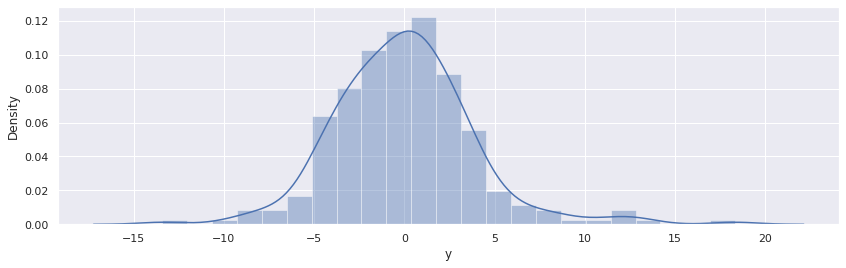

In [318]:
prophetdf = pd.DataFrame(columns=['ds','y'])
prophetdf['y'] = googletrends_droplastrow['Hulu: (United States)']
prophetdf['ds'] = googletrends_droplastrow.index

Xdf = pd.DataFrame()
Xdf['total_adspend'] = googletrends_droplastrow['TOTAL ADSPEND']
Xdf['smoothed_total_adspend'] = adspend_trend
# add as many predictors as you like! It's a LASSO model, so it can take it!


m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(prophetdf)
future = m.make_future_dataframe(periods=0, freq='M')
forecast = m.predict(future)
Xdf['yearly'] = list(forecast['yearly'])
Xdf['holidays'] = list(forecast['holidays'])
Xdf['trend'] = list(forecast['trend'])
Xdf['AR - Lag 1'] = prophetdf['y'].shift(-1)
Xdf = Xdf.interpolate(method='linear', axis=0)
Xdf['additive_terms'] = list(forecast['additive_terms'])



X = Xdf.to_numpy()

allpredictors = list(Xdf.columns)
model = LassoLarsCV(cv=10, precompute=False)
model.fit(X,prophetdf['y'])
predictors_model=pd.DataFrame(allpredictors)
predictors_model.columns = ['label']
predictors_model['coeff'] = model.coef_

predictions = model.predict(X)
residuals = prophetdf['y'] - predictions
squarederror = residuals ** 2
mse = np.mean(squarederror)
mae = np.mean(np.abs(residuals))
durbinwatson = durbin_watson(residuals)

sns.distplot(residuals, hist=True, kde=True)

coefficients = []
for index, row in predictors_model.iterrows():
    if row['coeff'] > 0:
        # print(row.values)
        coefficients.append([row[0], row[1]])
coefficientsdf = pd.DataFrame(coefficients, columns=['X (predictor)', 'coefficient'])
print(coefficientsdf)
print('R-square training: {0}'.format(model.score(X,prophetdf['y'])))
print('MSE: {0}'.format(mse))
import math
print('RMSE: {0}'.format(math.sqrt(mse)))
print('MAE: {0}'.format(mae))
print('Durbin-Watson: {0}'.format(durbinwatson))

##Review

Review Thoughts:
*   The concepts of timeseries are fascinating. We're modeling changes in time using various concepts: seasonality or autoregression
*   What is autoregression?
*   What is seasonality?
*   What is residual error?
*   What do you think is more likely to overfit the data, a seasonal approach or an autoregressive approach? Why?
*   What is an exogeneous variable?

##Going "Above and Beyond": Neural Networks

Here's a similar data example using neural networks at https://colab.research.google.com/drive/1Tf7ByYOH3a8wqnOFZMmX_nEfJoeXcReV?usp=sharing